In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchinfo import summary
from craft.craft_torch import Craft, torch_to_numpy
from art.attacks.evasion import FastGradientMethod, DeepFool, CarliniL2Method
from art.estimators.classification import PyTorchClassifier
from data.dataloader import *
from data.dataprocess import *
from model.resnet import ResNet18
from model.submodel import *
from model.method import *

2025-12-21 21:57:08.376676: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 21:57:09.100624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 21:57:12.839621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/aki/anaconda3/envs/adv-study/lib/python3.11/site-packages/keras/src/export/tf2onnx_li

In [8]:
# Create the model instance
model = ResNet18()

CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 200

# model.to(device=DEVICE)
summary(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]          128
├─ReLU: 1-3                              [64, 64, 32, 32]          --
├─Sequential: 1-4                        [64, 64, 32, 32]          --
│    └─ResBlock: 2-1                     [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [64, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 32, 32]          128
│    │    └─ReLU: 3-3                    [64, 64, 32, 32]          --
│    │    └─Conv2d: 3-4                  [64, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 32, 32]          128
│    │    └─Sequential: 3-6              [64, 64, 32, 32]          --
│    │    └─ReLU: 3-7                    [64, 64, 32, 32]          --
│

## Training

In [ ]:
train_ld, test_ld, val_ld = dataloader('CIFAR10', 128, True, 0.2, augment=True)
classes_name = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']
img_by_cl = {name: separation(test_ld, i) for i, name in enumerate(classes_name)}

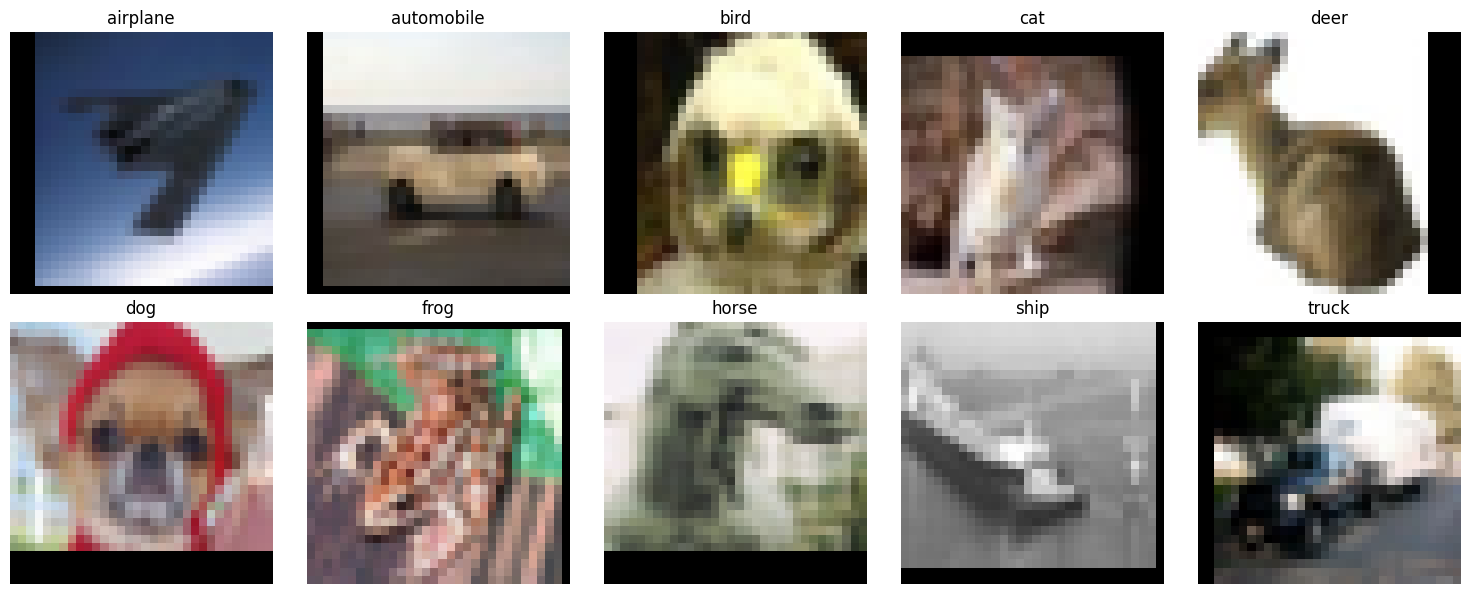

In [ ]:
# Prepare images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, name in enumerate(classes_name):
    # Get one image from each class
    img_test = img_by_cl[name][14]

    # Normalize and transpose
    img_test = img_test * 0.5 + 0.5
    img_test = img_test.permute(1, 2, 0).cpu().numpy()

    # Plot the image
    axes[i].imshow(img_test)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

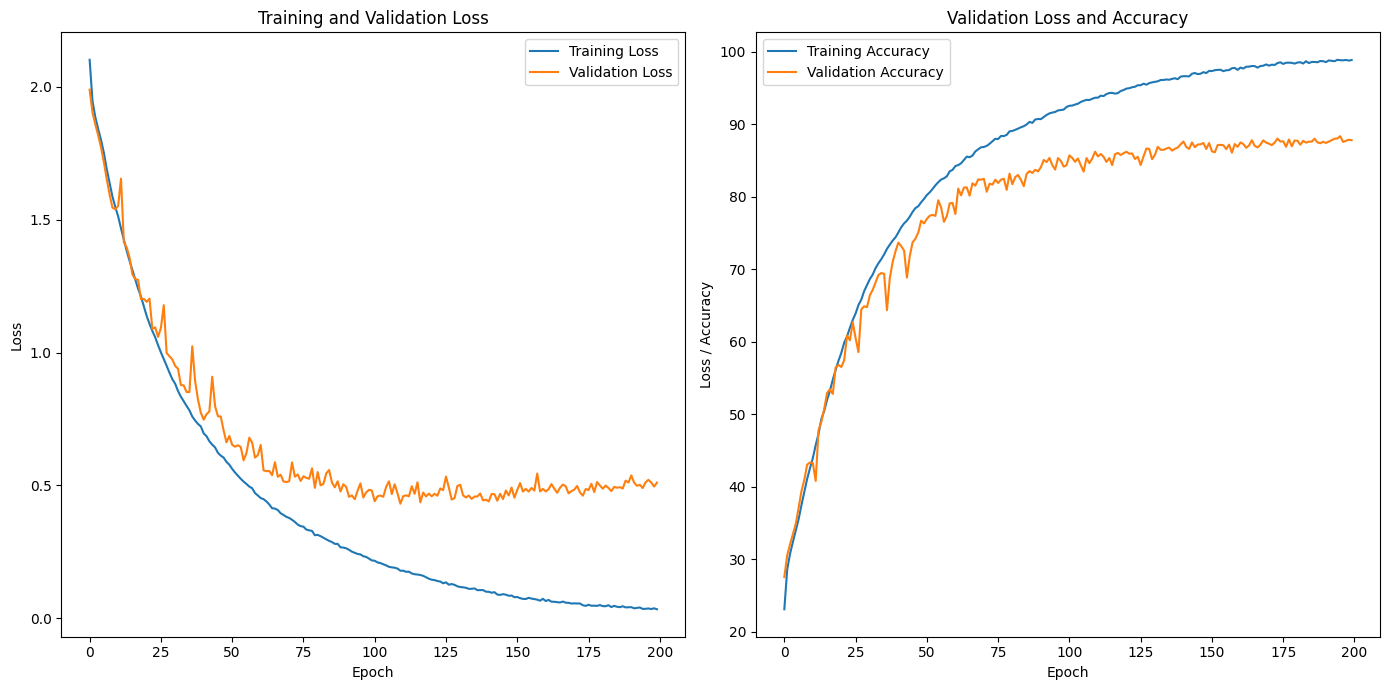

In [ ]:
train_losses, train_accuracy, val_losses, val_accuracy = training(model=model,
                                                                    train_loader=train_ld,
                                                                    criterion=CRITERION,
                                                                    optimizer=OPTIMIZER,
                                                                    device=DEVICE,
                                                                    epochs=EPOCHS,
                                                                    val_loader=val_ld)

    
# Plotting the Results
plt.figure(figsize=(14, 7))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation

In [ ]:
loss, accuracy = evaluating(model=model,
           data_loader=test_ld,
           criterion=CRITERION,
           device=DEVICE)

print(f"Test loss: {loss:.4f} | Test accuracy: {accuracy:.2f}%")

Test loss: 0.5077 | Test accuracy: 87.56%


In [13]:
x_train, y_train = get_tensors(train_ld)
x_test, y_test = get_tensors(test_ld, True)

x_train.shape, x_test.shape

(torch.Size([40000, 3, 32, 32]), (10000, 3, 32, 32))

## Concepts with CRAFT

In [14]:
# As explained in the paper related to CRAFT implementation,
# it is necessary to split the model in two part g and h and
# this case the model noted f, can be defind as follows:
# f = h . g
g, h = split(model=model)

In [17]:
# Create the CRAFT instance
craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 5,
              patch_size = 12,
              batch_size = 64,
              device = DEVICE)

H = []
for name in classes_name:
    # now we can start fit the concept using our images
    # CRAFT will (1) create the patches, (2) find the concept
    # and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
    _, _, w = craft.fit(img_by_cl[name])
    H.append(w)

# crops, crops_u, w = craft.fit(img_by_cl['airplane'])
# crops = np.moveaxis(torch_to_numpy(crops), 1, -1)

# crops.shape, crops_u.shape, w.shape

/home/aki/anaconda3/envs/adv-study/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/home/aki/anaconda3/envs/adv-study/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/home/aki/anaconda3/envs/adv-study/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])
/home/aki/ana

### Concepts visualization

In [ ]:
# for name in classes_name:  
#   importances = craft.estimate_importance(img_by_cl['airplane'], class_id=0)

#   plt.bar(range(len(importances)), importances)
#   plt.xticks(range(len(importances)))
#   plt.title("Concept Importance")

#   most_important_concepts = np.argsort(importances)[::-1][:5]

#   for c_id in most_important_concepts:
#     print("Concept", c_id, " has an importance value of ", importances[c_id])

/home/aki/anaconda3/envs/adv-study/lib/python3.11/site-packages/craft/craft_torch.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset[i:i+batch_size])


Concept 3  has an importance value of  0.9293766
Concept 1  has an importance value of  0.010180715
Concept 2  has an importance value of  0.0048078727
Concept 0  has an importance value of  0.0020974334
Concept 4  has an importance value of  0.0012749172


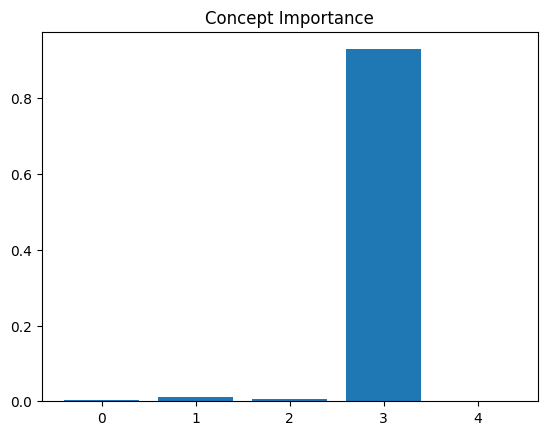

In [19]:
importances = craft.estimate_importance(img_by_cl['airplane'], class_id=0)

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")

most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

### Bank of concepts

In [20]:
HBD = np.concatenate(H, axis=0)
HBD.shape

(50, 512)

## Adversarial Generation

In [21]:
x_test = x_test.astype(np.float32)
print("Type test :", type(x_test), type(y_test))
print("Shape test :", x_test.shape, y_test.shape)

# Create the ART classifier instance
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=CRITERION,
    optimizer=OPTIMIZER,
    input_shape=(1, 3, 32, 32),
    nb_classes=10,
)

Type test : <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Shape test : (10000, 3, 32, 32) (10000,)


In [22]:
# Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
print("Type predictions :", type(predictions))
print("Shape predictions :", predictions.shape)

accuracy = np.sum(np.argmax(predictions, axis=1) == y_test.flatten()) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Type predictions : <class 'numpy.ndarray'>
Shape predictions : (10000, 10)
Accuracy on benign test examples: 87.55%


In [23]:
# Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)
print(x_test_adv.shape)

# Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test.flatten()) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

(10000, 3, 32, 32)
Accuracy on adversarial test examples: 22.61%


Shape img_adv : (3, 32, 32)
Shape img_adv : (32, 32, 3)


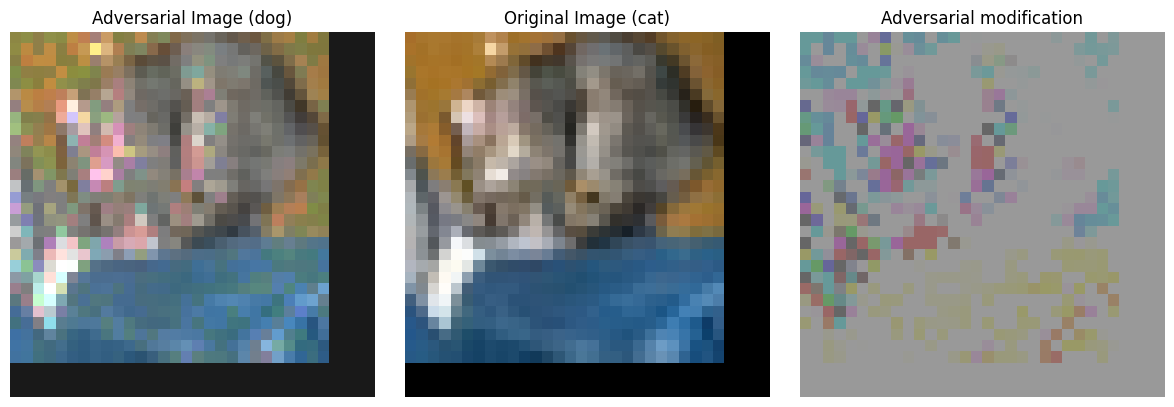

In [ ]:
# Prepare images
img_adv = x_test_adv[0]
img_orig = x_test[0]
img_diff = x_test_adv[0] - x_test[0]

y_img_adv = classes_name[np.argmax(predictions[0])]
y_img_orig = classes_name[y_test[0]]

img_adv = preparation(img_adv)
img_orig = preparation(img_orig)
img_diff = preparation(img_diff)

# Plot all images on the same figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

titles = [f'Adversarial Image ({y_img_adv})', f'Original Image ({y_img_orig})', 'Adversarial modification']

for ax, img, title in zip(axes, [img_adv, img_orig, img_diff], titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

C&W L_2: 100%|██████████| 1/1 [00:05<00:00,  5.98s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.47442913..1.0000002].


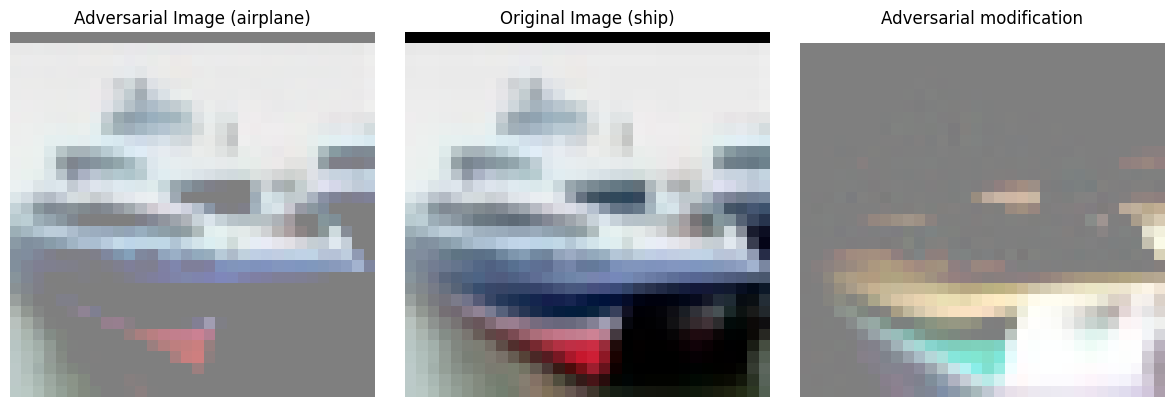

In [39]:
cw_test = np.array([x_test[1]])

CW_attack = CarliniL2Method(classifier=classifier)
x_adv = CW_attack.generate(x=cw_test)

pred = classifier.predict(x_adv)

# Prepare images
img_adv = x_adv.squeeze()
img_orig = x_test[1]
img_diff = img_adv - img_orig

y_img_adv = classes_name[np.argmax(pred)]
y_img_orig = classes_name[y_test[1]]

img_adv = preparation(img_adv)
img_orig = preparation(img_orig)
img_diff = preparation(img_diff)

# Plot all images on the same figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

titles = [f'Adversarial Image ({y_img_adv})', f'Original Image ({y_img_orig})', 'Adversarial modification']

for ax, img, title in zip(axes, [img_adv, img_orig, img_diff], titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Projection

## SVM